In [ ]:
# 필요한 라이브러리 호출하기
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm_notebook as tqdm

# 파이토치 Device설정하기
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# train데이터냐, validation 데이터냐에 따라서 다른 이미지 전처리를 해주는 class를 생성한다

class ImageTransform:
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
        ]),
        'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
        ])
    }

  def __call__(self, img, phase):
    return self.data_transform[phase](img)

In [ ]:
# 데이터를 가져와서 훈련, 검증, 테스트 용도로 분리한다
# 현재 Cat, Dog 디렉토리에 각각 251개의 이미지 데이터가 존재한다
# 이것을 일정 비율로 각 용도를 위하여 나누는 작업을 시행할 것이다

cat_directory = "./Cat"
dog_directory = "./Dog"

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]

400


In [ ]:
# 커스텀 데이터셋을 정의한다
# 물론 __init__, __len__, __getitem__ 메소드를 overriding하여야 한다

class DogvsCatDataset(Dataset):
  def __init__(self, file_list, transform = None, phase='train'):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, idx):
    img_path = self.file_list[idx]
    img = Image.open(img_path)
    img_transformed = self.transform(img, self.phase)

    label = img_path.split("/")[-1].split(".")[0]
    if label == "dog":
      label = 1
    elif label == "cat":
      label = 0

    return img_transformed, label

In [ ]:
# 전처리에서 필요한 여러 변수 값을 정의한다
size = 256

# AlexNet이 학습한 데이터들의 RGB채널 평균과 표준편차를 이용하여 정규화하여야 한다
# 그렇게 하여야 AlexNet모델이 정상적으로 작동한다

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [ ]:
# 훈련, 검증, 테스트 데이터셋을 정의하기

train_dataset = DogvsCatDataset(train_images_filepaths, transform = ImageTransform(size, mean, std), phase="train")
val_dataset = DogvsCatDataset(val_images_filepaths, transform = ImageTransform(size, mean, std), phase="val")
test_dataset = DogvsCatDataset(test_images_filepaths, transform = ImageTransform(size, mean, std), phase="val")

In [ ]:
# 정의된 Dataset으로부터 batch_size만큼의 데이터를 불러오는 DataLoader를 생성한다
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
dataloader_dict = {'train' : train_dataloader, 'val' : val_dataloader}

In [ ]:
# AlexNet model Network를 생성하기
class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True), 
        # ReLU에 inplace = True가 사용되면 렐루층 통과 이전의 데이터가 메모리상에서 사라지게 된다.
        # 메모리를 그만큼 절약할 수 있게 된다.
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6,6))
    # 풀링층 커널을 알아서 조작해서 (6,6) 형상으로 만들어주는 편리한 기능이다
    
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256*6*6, 4096),
        nn.ReLU(inplace=True),
        
        nn.Dropout(),
        nn.Linear(4096, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512,2)
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1) 
    # x라는 Tensor를 첫 번째 차원인 batch차원을 기준으로 flatten하라는 것이다
    # 그 결과 배치 개수만큼 (256*6*6,)의 펼쳐진 데이터가 반환된다.
    x = self.classifier(x)
    return x

In [ ]:
# 모델을 생성하고 cpu 또는 gpu상에서 연산을 할 수 있도록 model을 이동시킨다.

model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# optimizer와 손실함수를 정의하기
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [ ]:
# 모델의 네트워크 구조를 summary 메소드를 통하여 확인하기

from torchsummary import summary
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
# 모델 학습 함수 정의하기
import time

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
  since = time.time()
  best_acc = 0.0

  for epoch in range(num_epoch):
    print("Epoch {} / {}".format(epoch+1, num_epoch))
    print("-"*20)

    # 한 번의 Epoch당 학습과 평가를 동시에 시행한다
    for phase in ['train','val']:
      if phase == "train":
        model.train() # Training Mode
      else:
        model.eval() # Evaluation Mode

      epoch_loss = 0.0 # 한 에폭에서 발생한 총 손실함수값을 구한다
      epoch_corrects = 0 # 에폭 당 validation을 시행할 때 몇 개의 데이터를 맞추는지를 카운팅하기

      for inputs, labels in tqdm(dataloader_dict[phase]):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Train mode일 때만 기울기값을 계산하여 자원과 시간소모를 줄인다
        with torch.set_grad_enabled(phase == "train"):
          outputs = model(inputs)
          preds = torch.max(outputs, 1)[1] # 내가 예측한 labels
          loss = criterion(outputs, labels) # 내가 예측한 labels와 실제 labels를 비교하여 손실함수 값을 구한다

          if phase == "train":
            loss.backward()
            optimizer.step()

          epoch_loss += loss.item() * inputs.size(0) # loss.item()에서 에폭당 평균 손실이 반환. 여기다가 배치를 곱하여 총 손실값 구함
          epoch_corrects += torch.sum(preds == labels.data)

      epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

      print("{} Loss : {:.4f} Acc : {:.4f}".format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()

  time_elapsed = time.time() - since
  print("training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

  print("Best val Acc : {:.4f}".format(best_acc))
  return model

In [ ]:
# 본격적으로 모델 학습 시작하기
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

In [ ]:
# 모델 테스트를 위한 함수를 정의하기
# Test dataset을 모델에 적용하여 정확도를 측정하고, 측정 결과를 Dataframe으로 변환시켜 CSV파일로 저장할 예정이다.

import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad():
  for test_path in tqdm(test_images_filepaths):
    img = Image.open(test_path)
    _id = test_path.split("/")[-1].split(".")[1]
    # ./Cat/cat.2356.jpg 라는 파일 경로가 있을 때 해당 데이터셋 아이디인 2356을 추출하는 과정이다
    transform = ImageTransform(size, mean, std)
    img = transform(img, phase='val')
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()
    outputs = model(img)
    preds = F.softmax(outputs, dim=1)[:,1].tolist() # 해당 사진을 dog로 예측한 확률을 구한다
    id_list.append(_id)
    pred_list.append(preds[0])

  res = pd.DataFrame({
      'id' : id_list,
      'label' : pred_list
  })

  res.sort_values(by='id', inplace = True) # id순서대로 재 정렬한다
  res.reset_index(drop=True, inplace = True) # DataFrame의 인덱스를 0부터 재정렬

  res.to_csv("./alexnet", index=False) # 인덱스 열 없이 순수하게 데이터프레임의 데이터만 저장한다

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/10 [00:00<?, ?it/s]

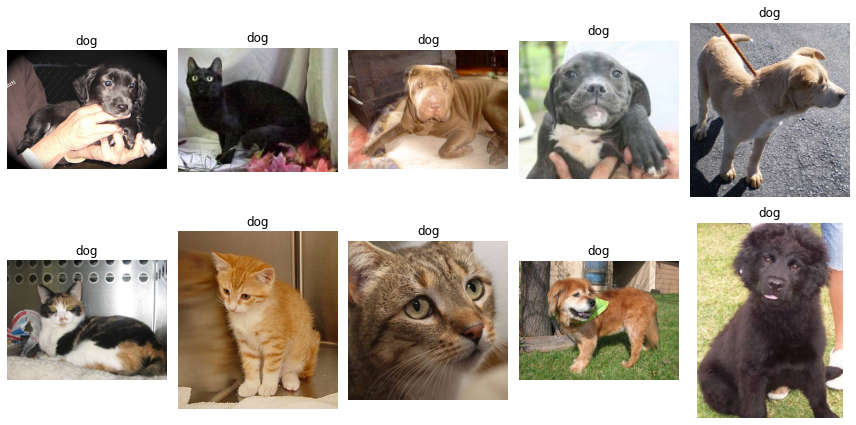

In [ ]:
# 테스트 데이터셋의 예측 결과를 시각적으로 표현하기 위한 함수를 정의한다
import matplotlib.pyplot as plt

class_ = {0:'cat', 1:'dog'}
def display_test_image_grid(images_filepaths, predicted_labels=(), cols=5):

  # 하나의 행에 다섯 개의 이미지를 출력시킬 것이다.
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6))

  for i, image_filepath in enumerate(images_filepaths):
    image = cv2.imread(image_filepath) # 사진을 읽어오고
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # matplotlib으로 다루기 위해 RGB형식으로 변환
    a = random.choice(res['id'].values) # 테스트 사진 데이터의 id를 무작위로 선택하여
    label = res.loc[res['id'] == a, 'label'].values[0] # 해당 사진을 어떻게 예측했는지 가져온다
    if label > 0.5:
      label = 1 # Dog
    else:
      label = 0 # Cat

    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(class_[label])
    ax.ravel()[i].set_axis_off()

  plt.tight_layout()
  plt.show()
  

display_test_image_grid(test_images_filepaths)